## Content Based Unsupervised Learning (Cosine Similarity)

# Introduction:
The main idea behind CBF is to recommend items similar to the items previously liked by the user. For example, if the user have rated some items in the past, then these items are used for user-modeling where the user’s interests are quantified.Cosine similarity is a method to measure the difference between two non zero vectors of an inner product space.

In [1]:
#IMPORT NEEDED LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path  
import os
import seaborn as sns
import plotly.express as px
import cv2
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\molla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Loading the Data**

In [3]:
article= pd.read_csv('D:/Datasciencebootcamp/Capstone/Submission/Article.csv')

In [4]:
transaction=pd.read_csv('D:/Datasciencebootcamp/Capstone/Submission/transaction.csv')

In [5]:
#this csv is the one we saved after EDA3 with article ids and joined description
article_description_clean= pd.read_csv('D:/Datasciencebootcamp/Capstone/Submission/Article_Description.csv')

**Due to memory issues I will change the customer_id type to reserve less memory.**

---

**Due to memory issues I will change the article_id type to reserve less memory.**

## Changing the columns type

In [6]:
#first checking the columns types
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28813419 entries, 0 to 28813418
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.1+ GB


In [7]:
#changing from string to integer
transaction['customer_id'] =\
    transaction['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')

In [8]:
#converting article id type in 3 csv files we have
transaction['article_id'] = transaction['article_id'].astype('int32')

In [9]:
article['article_id'] = article['article_id'].astype('int32')

In [10]:
article_description_clean['article_id'] = article_description_clean['article_id'].astype('int32')

## Query Function:

***Define a function to see the transactions between perefered date period:***

*   From Desired Start Date
*   To Desired End Date





In [12]:
#Because of the huge dataset I had I needed to try with different amount of data because even colab could not run some models so after definig the train dataset each time
#I decided to define a function to make it easier each time to choose the transactions after a specific date

#the default start date and end date is the min and max of the original transaction date
def query_date(df, start_date='2019-09-01', end_date='2020-09-22'):
    x = df[(df['t_dat']>start_date) & (df['t_dat']<=end_date)]
    return x

In [13]:
#Because of Memory issues for this model I look at the transactions in 4 days (3days for train and 1 day for test)
start_date = '2020-09-19'
x = query_date(transaction, start_date)

## Query Dataset:

In [14]:
#sanity check
x

,t_dat,customer_id,article_id,price,sales_channel_id
28726683,2020-09-20,8215006181404469139,624486001,0.013542,1
28726684,2020-09-20,8055340703569116761,871519008,0.033881,2
28726685,2020-09-20,-4092888402908209192,863646005,0.033881,1
28726686,2020-09-20,8717982620717986738,786304009,0.025407,2
28726687,2020-09-20,8717982620717986738,803757019,0.016932,2
...,...,...,...,...,...
28813414,2020-09-22,4685485978980270934,929511001,0.059305,2
28813415,2020-09-22,4685485978980270934,891322004,0.042356,2
28813416,2020-09-22,3959348689921271969,918325001,0.043203,1
28813417,2020-09-22,-8639340045377511665,833459002,0.006763,1


In [15]:
#number of unique items in the train dataset
x['article_id'].nunique()

12574

Ther are 12574 different unique article ids in the dataset.

Get the unique number of items from query and make a new dataframe named df with descriptions:

## Creating a dataframe with unique Items:

In [17]:
#list of unique items in the train
a=x['article_id'].unique()

In [18]:
df_train_items= pd.DataFrame(data=a, columns=['article_id'])

In [19]:
df_train_items

,article_id
0,624486001
1,871519008
2,863646005
3,786304009
4,803757019
...,...
12569,808699003
12570,789721001
12571,651337004
12572,864339003


The new dataframe has 12,574 rows and unique items.

## Preprocessing the Description of Items:

Now , We are going to vectorize the description columns of items and apply vectorization on it.

In [20]:
nltk.download('stopwords')
import re
from nltk.corpus import stopwords 

ENGLISH_STOP_WORDS = stopwords.words('english')

#define a function called my_tokenizer and recieves a sentence and preprocess and tokenize it in these 3 steps:
# 1-remove punctuation and set to lower case
# 2-split sentence into words
# 3-remove stopwords and any tokens that are just empty strings
# 4-find Stem words

def my_tokenizer(sentence):
    
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()
    
    
    
    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            
            # Stem words
            stemmer = nltk.stem.PorterStemmer()
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\molla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
#assigining a new name to the clean description article dataframe
article2=article_description_clean

In [22]:
#sanity check
article2.head()

,Unnamed: 0,article_id,description
0,0,108775015,strap top vest top garment upper body solid bl...
1,1,108775044,strap top vest top garment upper body solid wh...
2,2,108775051,strap top vest top garment upper body stripe o...
3,3,110065001,op shirt idro bra underwear solid black dark b...
4,4,110065002,op shirt idro bra underwear solid white light ...


In [23]:
#drop the unnamed column
article2=article2.drop(columns=['Unnamed: 0'], axis=1)

In [24]:
#merge the dataframe of unique items in train dataset with their clesn description
train_vectorize = pd.merge(df_train_items, article2,how='inner', on='article_id')

## Vectorization:

In [25]:
#sanity check
train_vectorize

,article_id,description
0,624486001,brit baby tee shirt garment upper body solid b...
1,871519008,judy vest top garment upper body solid light p...
2,863646005,matey sweater garment upper body solid white l...
3,786304009,sebi sweater garment upper body solid dark pur...
4,803757019,bradley trousers garment lower body solid dark...
...,...,...
12569,808699003,megan wedge wedge shoes solid dark yellow dark...
12570,789721001,brancusi pq ballerina ballerinas shoes solid b...
12571,651337004,cozy oversize raglan sweater garment upper bod...
12572,864339003,sid dress garment full body solid light blue d...


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [27]:
#applying the tfidf on the train dataset description
tfidf_vectorizer = TfidfVectorizer(tokenizer= my_tokenizer)
#fit
tfidf=tfidf_vectorizer.fit(train_vectorize['description']) 
#transform
X_train_transformed = tfidf.transform(train_vectorize['description'])


c:\Users\molla\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## Calculating the Cosine Similarity:

In [28]:
#inding the cosine similarities between items
from sklearn.metrics.pairwise import cosine_similarity 
similarities_train = cosine_similarity(X_train_transformed,X_train_transformed )

In [29]:
#check
similarities_train

array([[1.        , 0.05363889, 0.0530551 , ..., 0.11249982, 0.17465338,
        0.02626877],
       [0.05363889, 1.        , 0.12107543, ..., 0.07608198, 0.16640521,
        0.09924778],
       [0.0530551 , 0.12107543, 1.        , ..., 0.16693713, 0.09288656,
        0.04587336],
       ...,
       [0.11249982, 0.07608198, 0.16693713, ..., 1.        , 0.04369864,
        0.05928326],
       [0.17465338, 0.16640521, 0.09288656, ..., 0.04369864, 1.        ,
        0.06414007],
       [0.02626877, 0.09924778, 0.04587336, ..., 0.05928326, 0.06414007,
        1.        ]])

## Defining the Recommendation Function:

In [30]:
#defining similarities recommendation function

indices = pd.Series(train_vectorize.index, index=train_vectorize['article_id']).drop_duplicates()

def get_recommendations(article_id, similarities_train, indices):
    # Get the index of the items that matches the title
    idx = indices[article_id]
    # Get the pairwsie similarity scores
    sim_scores = list(enumerate(similarities_train[idx]))
    # Sort the items based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores for 10 most similar items
    sim_scores = sim_scores[1:11]
    # Get the item indices
    item_indices = [i[0] for i in sim_scores]
    # Return the top 10 most similar items
    return train_vectorize['article_id'].iloc[item_indices]

In [32]:
Rec=list(get_recommendations(863646005, similarities_train, indices))


In [33]:
for i in range(0,10):
    print(Rec[i])

863646001
863646004
863646003
863646002
870531001
842302002
842302001
825688005
911870004
826492007


In [34]:
images_dir = 'D:/images'

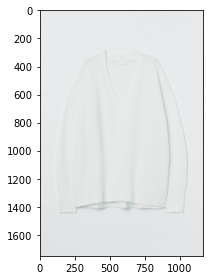

In [35]:
item_id=863646005
image_path = f'{images_dir}/0{str(item_id)[:2]}/0{item_id}.jpg'

#using cv2 to read the image
image=cv2.imread(image_path)

plt.imshow(image)
plt.tight_layout()

plt.show()

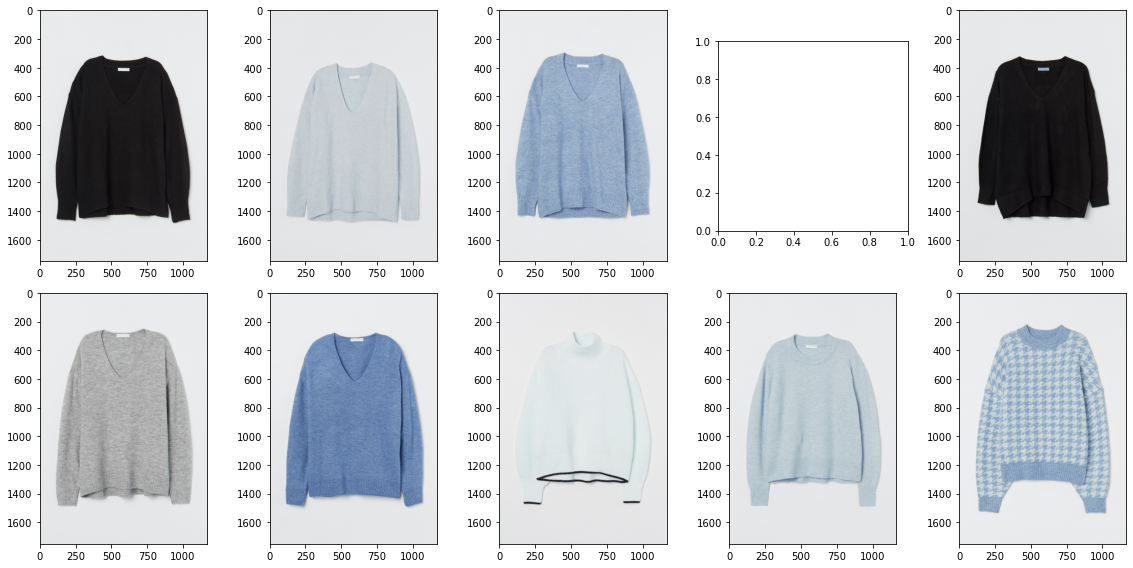

In [36]:
figure, ax = plt.subplots(nrows=2,ncols=5,figsize=(16,8))
for iid, im_id in enumerate(Rec):

    #that's how the image path is in my directory
        image_path = f'{images_dir}/0{str(im_id)[:2]}/0{im_id}.jpg'
        
        #using cv2 to read the image
        image=cv2.imread(image_path)
        
        try:
            #flatten it and then show it
            ax.ravel()[iid].imshow(image)
            
        except:
            continue;
            
#first plotting the layout of images            
plt.tight_layout()

#showing the whole set of images
plt.show()

#I first tried the first 8 lines of the code 

# Conclusion:
I did not create an evaluation metric nor did build any statistics on its performance. I did manual explorations selecting multiple items I’ve like and observed the results, which did pretty well.